# NVIDIA Nemotron Nano 2 VL on Fireworks AI

This notebook demonstrates how to use NVIDIA Nemotron Nano 2 VL, a powerful 12B multimodal reasoning model for document intelligence and product catalog cleansing deployed on Fireworks AI.


## Table of Contents

1. Introduction to NVIDIA Nemotron Nano 2 VL
2. Setting Up Deployment on Fireworks AI
3. Performance and Speed Metrics
4. Use Cases
   - Document Intelligence
   - Product Catalog Cleansing

## 1. Introduction to NVIDIA Nemotron Nano 2 VL

### Overview

NVIDIA Nemotron Nano 2 VL is the strongest open 12B multimodal reasoning model for document intelligence and image analysis. Built on a hybrid transformer-Mamba architecture, it combines the best of both worlds:

- **Accuracy on par with transformer-only models**
- **Limited memory and compute usage from Mamba architecture**
- **Higher token throughput and lower latency**

### Key Features

#### Highest Accuracy
- Trained with NVIDIA curated high-quality synthetic data
- Best-in-class accuracy for:
  - Character recognition (OCR)
  - Chart reasoning
  - Image understanding
  - Video understanding
  - Document intelligence
- **73.2 average score** vs 64.2 with current top VL model on benchmarks including MMMU, MathVista, AI2D, OCRBench, OCRBench-v2, OCR-Reasoning, ChartQA, DocVQA, and Video-MME


### Use Cases

1. **Document Intelligence**
   - IT, finance, insurance, healthcare forms

2. **Content Ingestion**
   - Product catalog cleansing
   - Dense captioning of images/videos

3. **Multi-modal Applications**
   - RAG systems with complex documents, figures, graphs, etc
   - Agentic apps and services

## 2. Setting up on demand deployment on Fireworks AI

### Prerequisites

Before getting started, you'll need:
- A Fireworks AI account ([sign up here](https://fireworks.ai))
- API key from Fireworks AI dashboard ([get one here](https://app.fireworks.ai/settings/users/api-keys))
- Python 3.8 or higher

### Installation

Install the required packages:

In [1]:
! uv pip install -r ../requirements.txt

Using Python 3.12.10 environment at: /Users/robertobarroso/Desktop/repos/cookbook/learn/vlm/.venv
Audited 6 packages in 56ms


### Environment Setup

Set up your Fireworks AI API key:

In [18]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import base64
import requests
from pydantic import BaseModel, Field
from datasets import load_dataset, disable_progress_bars
import json
import pandas as pd
from IPython.display import display
import ast
import re
from typing import List, Dict, Any, Optional, Callable
from enum import Enum
from PIL import Image
from io import BytesIO
from typing import Union

disable_progress_bars()

load_dotenv()

FIREWORKS_API_KEY = os.getenv('FIREWORKS_API_KEY')

if not FIREWORKS_API_KEY:
    raise ValueError("Please set FIREWORKS_API_KEY environment variable")

### Create on-demand deployment for NVIDIA Nemotron Nano 2 VL

Creating an [on-demand deployment](https://fireworks.ai/docs/getting-started/ondemand-quickstart#on-demand-quickstart) for proper testing and benchmarks

In [5]:
! firectl-admin signin

Signed in as: barrosoluque.roberto@fireworks.ai
Use the arrow keys to navigate: ↓ ↑ → ← 
? Select a default account. If you do not choose a default account, pass `-a <ACCOUNT_ID>` when running firectl commands: 
  ▸ <None>
    airbnb
    aws-fireworkai-trainings
    bcg
↓   fireworks
J[
2025/10/20 15:34:52 Failed to execute: error finding default account ID: error selecting account: ^C


In [6]:
# TODO: Update to NVIDIA Nemotron Nano 2 VL when available
! firectl create deployment -a <YOUR-ACCOUNT-ID-HERE> accounts/fireworks/models/qwen3-vl-30b-a3b-instruct --min-replica-count 1 --max-replica-count 1 --accelerator-type NVIDIA_H100_80GB

Name: accounts/pyroworks/deployments/d6djkqnw
Create Time: 2025-10-20 15:35:58
Expire Time: 2025-10-27 15:35:58
Created By: barrosoluque.roberto@fireworks.ai
State: CREATING
Status: OK
Min Replica Count: 1
Max Replica Count: 1
Desired Replica Count: 0
Replica Count: 0
Autoscaling Policy: disabled
Base Model: accounts/fireworks/models/qwen3-vl-30b-a3b-instruct
Accelerator Count: 2
Accelerator Type: NVIDIA_H100_80GB
Precision: PRECISION_UNSPECIFIED
World Size: 2
Generator Count: 1
Max Batch Size: 128
Enable Addons: false
Max Peft Batch Size: 16
Kv Cache Memory Pct: 80
Direct Route Type: DIRECT_ROUTE_TYPE_UNSPECIFIED
Auto Tune:
Placement:
  Region: REGION_UNSPECIFIED
  Multi Region: GLOBAL
Region: US_WASHINGTON_2
Engine: VLLM
Update Time: 2025-10-20 15:35:58
Cleanup Delay: 0s
Log Level: INFO
Hot Load Bucket Type: BUCKET_TYPE_UNSPECIFIED
Model Extra Args: [--tool-call-parser=hermes, --enable-auto-tool-choie]
Model Image Tag inherited: 4.2.2-feature-new-vllm-version-qwen3-vl.0


In [13]:
! firectl -a <YOUR-ACCOUNT-ID-HERE> get deployment <YOUR-DEPLOYMENT-ID>

Name: accounts/pyroworks/deployments/d6djkqnw
Create Time: 2025-10-20 15:35:58
Expire Time: 2025-10-27 15:35:58
Created By: barrosoluque.roberto@fireworks.ai
State: READY
Status: OK
Annotations:
  image-tag-reason=Persisted by deployment watcher
Min Replica Count: 1
Max Replica Count: 1
Desired Replica Count: 1
Replica Count: 1
Autoscaling Policy: disabled
Base Model: accounts/fireworks/models/qwen3-vl-30b-a3b-instruct
Accelerator Count: 2
Accelerator Type: NVIDIA_H100_80GB
Precision: PRECISION_UNSPECIFIED
World Size: 2
Generator Count: 1
Max Batch Size: 128
Enable Addons: false
Max Peft Batch Size: 16
Kv Cache Memory Pct: 80
Image Tag: 4.2.2-feature-new-vllm-version-qwen3-vl.0
Direct Route Type: DIRECT_ROUTE_TYPE_UNSPECIFIED
Auto Tune:
Placement:
  Region: REGION_UNSPECIFIED
  Multi Region: GLOBAL
Region: US_WASHINGTON_2
Engine: VLLM
Update Time: 2025-10-20 15:50:06
Cleanup Delay: 0s
Log Level: INFO
Hot Load Bucket Type: BUCKET_TYPE_UNSPECIFIED
Model Extra Args: [--tool-call-parser=he

In [3]:
# TODO: Update to Nvidia Nemotron and placeholder for model id
MODEL_NAME = "accounts/pyroworks/deployedModels/qwen3-vl-30b-a3b-instruct-l7ewe3ku"

### Helper Functions

Utility functions for encoding images and making API calls:

In [4]:
client = OpenAI(
    api_key=FIREWORKS_API_KEY or os.getenv("FIREWORKS_API_KEY"),
    base_url="https://api.fireworks.ai/inference/v1",
)

def encode_image_to_base64(image_path: str) -> str:
    """
    Encode an image file to base64 string.

    Args:
        image_path: Path to the image file

    Returns:
        Base64 encoded string of the image
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def encode_pil_image_to_base64(pil_image: Image.Image) -> str:
    """
    Encode a PIL Image to base64 string.

    Args:
        pil_image: PIL Image object

    Returns:
        Base64 encoded string of the image
    """
    if pil_image.mode not in ('RGB', 'L'):
        pil_image = pil_image.convert('RGB')

    buffer = BytesIO()
    pil_image.save(buffer, format='JPEG')
    buffer.seek(0)

    return base64.b64encode(buffer.read()).decode('utf-8')

def encode_image_url(image_url: str) -> str:
    """
    Download and encode an image from a URL.

    Args:
        image_url: URL of the image

    Returns:
        Base64 encoded string of the image
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(image_url, headers=headers, timeout=30)
    response.raise_for_status()

    try:
        image = Image.open(BytesIO(response.content))

        if image.mode not in ('RGB', 'L'):
            image = image.convert('RGB')

        buffer = BytesIO()
        image.save(buffer, format='JPEG')
        buffer.seek(0)

        return base64.b64encode(buffer.read()).decode('utf-8')
    except Exception as e:
        raise ValueError(f"Failed to process image from URL: {str(e)}")


def analyze_image(
        image_source: Union[str, Image.Image],
        prompt: str,
        structured_schema=None,
        is_url: bool = False,
        max_tokens: int = 1000
):
    """
    Analyze an image using the VLM model.

    Args:
        image_source: Path to image file, URL, or PIL Image object
        prompt: Text prompt for the model
        structured_schema: Structured schema for the response based on Pydantic class
        is_url: Whether image_source is a URL (ignored if PIL Image provided)
        max_tokens: Maximum tokens in response

    Returns:
        Model response (parsed object if structured_schema provided, else string)
    """
    # Determine image type and encode appropriately
    if isinstance(image_source, Image.Image):
        image_b64 = encode_pil_image_to_base64(image_source)
    elif is_url:
        image_b64 = encode_image_url(image_source)
    else:
        image_b64 = encode_image_to_base64(image_source)

    # Build message structure
    messages = [{
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}
            },
        ],
    }]

    # Call appropriate API method based on structured output requirement
    if structured_schema:
        response = client.chat.completions.parse(
            model=MODEL_NAME,
            messages=messages,
            max_tokens=max_tokens,
            response_format=structured_schema,
        )
        return response.choices[0].message.parsed
    else:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=messages,
            max_tokens=max_tokens,
        )
        return response.choices[0].message.content

### Basic Usage Example

Quick example to verify the setup works:

In [5]:
# Example with a URL image
test_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"

result = analyze_image(
    image_source=test_image_url,
    prompt="Describe this image in a 2-3 sentences.",
    is_url=True
)

print("Model Response:\n")
print(result)

Model Response:

A wooden boardwalk stretches through a vibrant green field of tall grass, leading the eye toward a distant treeline under a vast, blue sky filled with wispy white clouds. The scene is bathed in the warm, golden light of either early morning or late afternoon, creating a peaceful and inviting atmosphere.


## 3. Performance and Speed Metrics

### Benchmarking Setup

Let's measure the performance characteristics of the model on Fireworks AI.

In [ ]:
## TODO: Add / clone llm_bench and run benchmarks vs other VL models

### Run Performance Benchmark

In [ ]:
## TODO

### Expected Performance with Nemotron Nano 2 VL

Based on NVIDIA's specifications, Nemotron Nano 2 VL offers:

## TODO: update based on above
- **Up to 10x higher throughput** compared to Llama Nemotron Nano VL
- **Efficient Video Sampling (EVS)** for processing longer videos
- **128k context length** support
- **Low latency inference** thanks to the hybrid Mamba architecture

**Note:** Actual performance metrics will be updated once the model is available on Fireworks AI.

## 4. Use Cases

### 4.1 Document Intelligence

Nemotron Nano 2 VL excels at understanding complex documents including:
- Forms and invoices (see snippets below for examples)
- Screenshots and dashboards
- Healthcare and insurance documents
- Financial reports

Let's explore document intelligence capabilities:

#### OCR and Text Extraction

Extract text from invoices with high accuracy:

Loading 5 image samples...
Successfully loaded 5 samples

DataFrame shape: (5, 5)
Columns: ['image', 'invoice_date', 'invoice_no', 'items', 'summary']

First row preview:
  Invoice No: 40378170
  Invoice Date: 10/15/2012
  Number of items: 1
  Summary of purchase: {'total_net_worth': '$7,50', 'total_vat': '$0,75', 'total_gross_worth': '$8,25'} 

Invoice Example:


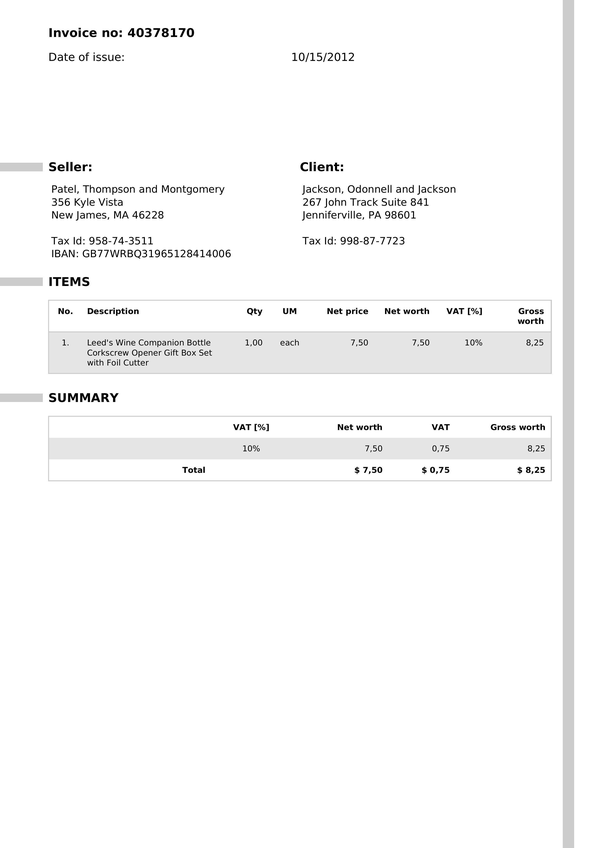

In [12]:
def extract_invoice_data(sample: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    Extract relevant invoice fields from a dataset sample.

    Args:
        sample: Raw sample from the HuggingFace dataset

    Returns:
        Dictionary with extracted fields, or None if parsing fails
    """
    try:
        parsed_data = json.loads(sample['parsed_data'])
        structured_json = ast.literal_eval(parsed_data['json'])
        header = structured_json.get('header', {})

        return {
            'image': sample['image'],
            'invoice_date': header.get('invoice_date'),
            'invoice_no': header.get('invoice_no'),
            'items': structured_json.get('items', []),
            'summary': structured_json.get('summary', {})
        }
    except (json.JSONDecodeError, KeyError, TypeError, ValueError, SyntaxError) as e:
        print(f"Warning: Failed to parse sample {sample.get('id', 'unknown')}: {type(e).__name__}: {e}")
        return None

def load_dataset_from_hf(dataset_name: str, func_extract: Callable, n_samples: int = 5) -> pd.DataFrame:
    """
    Load invoice samples from HuggingFace dataset and convert to DataFrame.

    Args:
        dataset_name: Name of the HuggingFace dataset
        n_samples: Number of samples to load

    Returns:
        DataFrame with columns: image, invoice_date, invoice_no, items, summary
    """
    print(f"Loading {n_samples} image samples...")

    # Load dataset in streaming mode
    ds = load_dataset(dataset_name, split="train", streaming=True)

    samples = []
    for i, sample in enumerate(ds):
        if i >= n_samples:
            break

        extracted = func_extract(sample)
        if extracted:
            samples.append(extracted)

    if not samples:
        raise ValueError(f"Failed to parse any samples. Check error messages above.")

    print(f"Successfully loaded {len(samples)} samples\n")

    df = pd.DataFrame(samples)

    return df

def resize_image_for_display(image: Image.Image, max_width: int = 600) -> Image.Image:
    """
    Resize image maintaining aspect ratio.

    Args:
        image: PIL Image object
        max_width: Maximum width in pixels

    Returns:
        Resized PIL Image
    """
    if image.width <= max_width:
        return image

    aspect_ratio = image.height / image.width
    new_height = int(max_width * aspect_ratio)

    return image.resize((max_width, new_height), Image.Resampling.LANCZOS)

df_invoices = load_dataset_from_hf(
    dataset_name="mychen76/invoices-and-receipts_ocr_v1",
    func_extract=extract_invoice_data,
    n_samples=5
)

print(f"DataFrame shape: {df_invoices.shape}")
print(f"Columns: {df_invoices.columns.tolist()}")


print(f"\nFirst row preview:")
print(f"  Invoice No: {df_invoices.iloc[0]['invoice_no']}")
print(f"  Invoice Date: {df_invoices.iloc[0]['invoice_date']}")
print(f"  Number of items: {len(df_invoices.iloc[0]['items'])}")
print(f"  Summary of purchase: {df_invoices.iloc[0]["summary"]} ")

print("\n" + "="*80)
print("Invoice Example:")
print("="*80)
_first_image = resize_image_for_display(df_invoices.iloc[0]['image'], max_width=600)
display(_first_image)

Use pydantic classes to set structured output for invoice data extraction

In [7]:
class InvoiceItem(BaseModel):
    """Individual line item on an invoice"""
    description: str = Field(description="Description of the item or service")
    quantity: str = Field(description="Quantity ordered")
    unit_price: str = Field(description="Price per unit")
    net_worth: str = Field(description="Total price before tax")
    vat_rate: Optional[str] = Field(default=None, description="VAT/tax rate percentage")
    gross_worth: str = Field(description="Total price including tax")

class InvoiceData(BaseModel):
    """Structured invoice data extraction"""
    invoice_no: str = Field(description="Invoice number or ID")
    invoice_date: str = Field(description="Invoice date in original format")
    items: List[InvoiceItem] = Field(description="List of items on the invoice")
    total_gross_worth: str = Field(description="Total amount including all taxes")


In [8]:
def normalize_currency(value: str) -> Optional[float]:
    """
    Normalize currency string to float for comparison.
    Handles various formats: $8,25 | 8,25 | $ 544,46 | 57 483,07

    Args:
        value: Currency string in various formats

    Returns:
        Float value or None if parsing fails
    """
    if not value:
        return None

    try:
        # Remove currency symbols and spaces
        cleaned = re.sub(r'[$€£¥\s]', '', str(value))

        # Handle European format (comma as decimal separator)
        # Check if there's a comma after the last space/digit group
        if ',' in cleaned:
            # If comma appears after the last space, it's likely decimal
            # e.g., "1 767,34" or "8,25"
            parts = cleaned.split(',')
            if len(parts) == 2 and len(parts[1]) == 2:
                # Likely decimal format: remove any remaining separators and replace comma
                cleaned = parts[0].replace('.', '').replace(' ', '') + '.' + parts[1]
            else:
                # Comma as thousands separator
                cleaned = cleaned.replace(',', '')

        return float(cleaned)
    except (ValueError, AttributeError) as e:
        print(f"Warning: Could not parse currency '{value}': {e}")
        return None


def compare_invoice_extraction(df: pd.DataFrame, model_name: str = MODEL_NAME) -> List[Dict[str, Any]]:
    """
    Extract invoice data from all images and compare with ground truth.

    Args:
        df: DataFrame with invoice images and ground truth data
        model_name: Name of the model being used

    Returns:
        List of comparison results
    """
    invoice_prompt = """
    Extract the following information from this invoice:
    - Invoice number
    - Invoice date
    - All line items with descriptions, quantities, and prices
    - Total gross worth (final amount including taxes)
        """

    results = []

    print(f"Analyzing {len(df)} invoices with {model_name}...")
    print("="*100)

    for idx, row in df.iterrows():
        print(f"\n{'='*100}")
        print(f"INVOICE {idx + 1}/{len(df)}")
        print(f"{'='*100}")

        # Extract using model
        try:
            extracted = analyze_image(
                image_source=row['image'],
                prompt=invoice_prompt,
                structured_schema=InvoiceData,
                max_tokens=2000
            )

            # Ground truth values
            gt_invoice_no = row['invoice_no']
            gt_date = row['invoice_date']
            gt_total = row['summary']['total_gross_worth']
            gt_items = row['items']

            # Extracted values
            ex_invoice_no = extracted.invoice_no
            ex_date = extracted.invoice_date
            ex_total = extracted.total_gross_worth
            ex_items = extracted.items

            # Normalize currency values for comparison
            gt_total_float = normalize_currency(gt_total)
            ex_total_float = normalize_currency(ex_total)

            # Calculate matches
            invoice_match = gt_invoice_no == ex_invoice_no
            date_match = gt_date == ex_date

            # Compare currency with tolerance for floating point precision
            if gt_total_float is not None and ex_total_float is not None:
                total_match = abs(gt_total_float - ex_total_float) < 0.01
            else:
                total_match = False

            item_count_match = len(gt_items) == len(ex_items)

            # Print comparison
            print(f"\n{'Field':<20} {'Ground Truth':<25} {'Extracted':<25} {'Match'}")
            print(f"{'-'*20} {'-'*25} {'-'*25} {'-'*5}")
            print(f"{'Invoice No':<20} {gt_invoice_no:<25} {ex_invoice_no:<25} {'✓' if invoice_match else '✗'}")
            print(f"{'Date':<20} {gt_date:<25} {ex_date:<25} {'✓' if date_match else '✗'}")
            print(f"{'Total (raw)':<20} {gt_total:<25} {ex_total:<25} {'✓' if total_match else '✗'}")
            print(f"{'Total (float)':<20} {f'{gt_total_float:.2f}' if gt_total_float else 'N/A':<25} {f'{ex_total_float:.2f}' if ex_total_float else 'N/A':<25} {'✓' if total_match else '✗'}")
            print(f"{'Item Count':<20} {len(gt_items):<25} {len(ex_items):<25} {'✓' if item_count_match else '✗'}")

            # Print item details
            print(f"\nLine Items:")
            print(f"  Ground Truth: {len(gt_items)} items")
            for i, item in enumerate(gt_items, 1):
                print(f"    {i}. {item['item_desc'][:60]}... | Qty: {item['item_qty']} | Total: {item['item_gross_worth']}")

            print(f"\n  Extracted: {len(ex_items)} items")
            for i, item in enumerate(ex_items, 1):
                print(f"    {i}. {item.description[:60]}... | Qty: {item.quantity} | Total: {item.gross_worth}")

            results.append({
                'index': idx,
                'invoice_no_match': invoice_match,
                'date_match': date_match,
                'total_match': total_match,
                'item_count_match': item_count_match,
                'ground_truth': {
                    'invoice_no': gt_invoice_no,
                    'date': gt_date,
                    'total_raw': gt_total,
                    'total_float': gt_total_float,
                    'item_count': len(gt_items)
                },
                'extracted': {
                    'invoice_no': ex_invoice_no,
                    'date': ex_date,
                    'total_raw': ex_total,
                    'total_float': ex_total_float,
                    'item_count': len(ex_items)
                }
            })

        except Exception as e:
            print(f"\n❌ ERROR: Failed to process invoice {idx + 1}")
            print(f"   Error: {str(e)}")
            results.append({
                'index': idx,
                'error': str(e)
            })

    return results

# Run comparison
comparison_results = compare_invoice_extraction(df_invoices)

# Summary statistics
print(f"\n{'='*100}")
print("SUMMARY")
print(f"{'='*100}")

successful_results = [r for r in comparison_results if 'error' not in r]
if successful_results:
    accuracy_df = pd.DataFrame(successful_results)

    print(f"\nTotal Invoices Processed: {len(df_invoices)}")
    print(f"Successful Extractions: {len(successful_results)}")
    print(f"Failed Extractions: {len(comparison_results) - len(successful_results)}")

    print(f"\nField Accuracy:")
    print(f"  Invoice Number: {accuracy_df['invoice_no_match'].mean():.1%}")
    print(f"  Date:           {accuracy_df['date_match'].mean():.1%}")
    print(f"  Total Amount:   {accuracy_df['total_match'].mean():.1%}")
    print(f"  Item Count:     {accuracy_df['item_count_match'].mean():.1%}")
    print(f"\nOverall Accuracy: {accuracy_df[['invoice_no_match', 'date_match', 'total_match', 'item_count_match']].mean().mean():.1%}")

Analyzing 5 invoices with accounts/pyroworks/deployedModels/qwen3-vl-30b-a3b-instruct-l7ewe3ku...

INVOICE 1/5

Field                Ground Truth              Extracted                 Match
-------------------- ------------------------- ------------------------- -----
Invoice No           40378170                  40378170                  ✓
Date                 10/15/2012                10/15/2012                ✓
Total (raw)          $8,25                     8,25                      ✓
Total (float)        8.25                      8.25                      ✓
Item Count           1                         1                         ✓

Line Items:
  Ground Truth: 1 items
    1. Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set w... | Qty: 1,00 | Total: 8,25

  Extracted: 1 items
    1. Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set w... | Qty: 1,00 | Total: 8,25

INVOICE 2/5

Field                Ground Truth              Extracted                 Match
---------

### 4.2 Product Catalog Cleansing

Use Nemotron Nano 2 VL to clean and enrich product catalog data by:
- Extracting product attributes from images, in this case category, subcategory, product type and material from fashion pictures
- Generating accurate descriptions
- Categorizing products automatically

#### Product Attribute Extraction

Extract detailed attributes from product images

https://huggingface.co/datasets/ivanleomk/ecommerce-taxonomy

In [10]:
def extract_ecommerce_data(sample: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    Extract ecommerce data

    Args:
        sample: Raw sample from the HuggingFace dataset

    Returns:
        Dictionary with extracted fields, or None if parsing fails
    """
    try:
        return {
            'image': sample['image'],
            "category": sample['category'],
            "subcategory": sample['subcategory'],
            "product_type": sample['product_type'],
            "material": sample['material'],
        }
    except (json.JSONDecodeError, KeyError, TypeError, ValueError, SyntaxError) as e:
        print(f"Warning: Failed to parse sample {sample.get('id', 'unknown')}: {type(e).__name__}: {e}")
        return None


Loading 50 image samples...
Successfully loaded 50 samples

DataFrame shape: (50, 5)
Columns: ['image', 'category', 'subcategory', 'product_type', 'material']

First row preview:
image           <PIL.JpegImagePlugin.JpegImageFile image mode=...
category                                                    Women
subcategory                                                  Tops
product_type                                            Tank Tops
material                                                   Cotton
Name: 0, dtype: object

Unique categories: ['Women']
Unique subcategories: ['Tops', 'Bottoms', 'Outerwear']
Unique product types: ['Tank Tops', 'T-Shirts', 'Skirts', 'Shorts', 'Vests', 'Jeans', 'Blouses', 'Pants', 'Cardigans']
Unique materials: ['Cotton', 'Polyester', 'Denim', 'Silk', 'Linen']

Ecommerce picture Example:


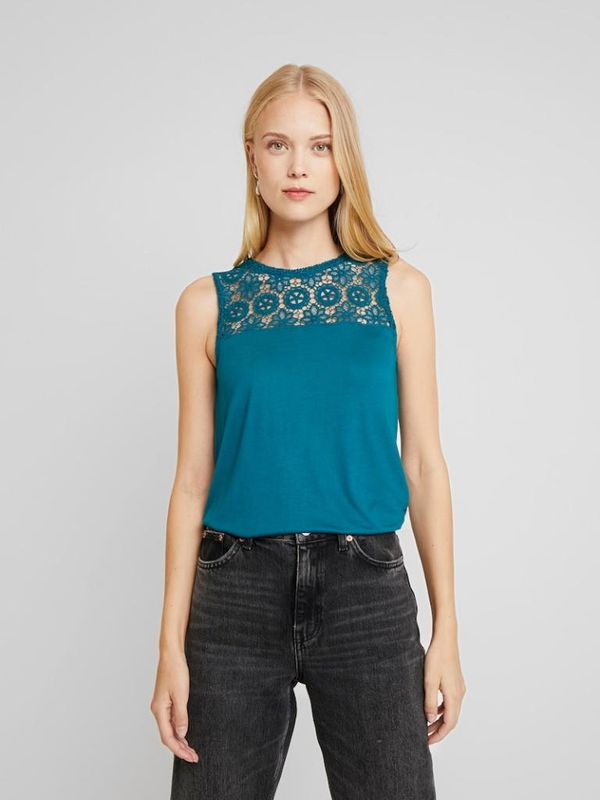

In [16]:
df_ecommerce = load_dataset_from_hf(
    dataset_name="ivanleomk/ecommerce-taxonomy",
    func_extract=extract_ecommerce_data,
    n_samples=50
)

print(f"DataFrame shape: {df_ecommerce.shape}")
print(f"Columns: {df_ecommerce.columns.tolist()}")


print(f"\nFirst row preview:")
print(df_ecommerce.iloc[0])

# Print unique category, subcategory, product_type and material
print(f"\nUnique categories: {df_ecommerce['category'].unique().tolist()}")
print(f"Unique subcategories: {df_ecommerce['subcategory'].unique().tolist()}")
print(f"Unique product types: {df_ecommerce['product_type'].unique().tolist()}")
print(f"Unique materials: {df_ecommerce['material'].unique().tolist()}")

print("\n" + "="*80)
print("Ecommerce picture Example:")
print("="*80)
_first_image = resize_image_for_display(df_ecommerce.iloc[0]['image'], max_width=600)
display(_first_image)

In [20]:
class Subcategory(str, Enum):
    """Valid subcategories"""
    TOPS = "Tops"
    BOTTOMS = "Bottoms"
    OUTERWEAR = "Outerwear"

class ProductType(str, Enum):
    """Valid product types"""
    TANK_TOPS = "Tank Tops"
    T_SHIRTS = "T-Shirts"
    SKIRTS = "Skirts"
    SHORTS = "Shorts"
    VESTS = "Vests"
    JEANS = "Jeans"
    BLOUSES = "Blouses"
    PANTS = "Pants"
    CARDIGANS = "Cardigans"

class Material(str, Enum):
    """Valid materials"""
    COTTON = "Cotton"
    POLYESTER = "Polyester"
    DENIM = "Denim"
    SILK = "Silk"
    LINEN = "Linen"

class EcommerceProduct(BaseModel):
    """E-commerce product classification"""
    subcategory: Subcategory = Field(
        description="Product subcategory: Tops, Bottoms, or Outerwear"
    )
    product_type: ProductType = Field(
        description="Specific product type: Tank Tops, T-Shirts, Skirts, Shorts, Vests, Jeans, Blouses, Pants, or Cardigans"
    )
    material: Material = Field(
        description="Primary material: Cotton, Polyester, Denim, Silk, or Linen"
    )

In [22]:
def compare_ecommerce_classification(
    df: pd.DataFrame,
    model_name: str = MODEL_NAME,
    sample_size: Optional[int] = None
) -> List[Dict[str, Any]]:
    """
    Classify e-commerce products and compare with ground truth.

    Args:
        df: DataFrame with product images and ground truth labels
        model_name: Name of the model being used
        sample_size: Number of samples to process (None = all)

    Returns:
        List of comparison results
    """
    ecommerce_prompt = """
    Classify this clothing product image by analyzing its visual characteristics.

    Provide:
    1. Subcategory: Choose from Tops, Bottoms, or Outerwear
    2. Product Type: Choose from Tank Tops, T-Shirts, Skirts, Shorts, Vests, Jeans, Blouses, Pants, or Cardigans
    3. Material: Choose from Cotton, Polyester, Denim, Silk, or Linen

    Base your classification on what you can see in the image.
        """

    df_sample = df.head(sample_size) if sample_size else df

    results = []

    print(f"Analyzing {len(df_sample)} products with {model_name}...")
    print("="*100)

    for _idx, row in df_sample.iterrows():
        print(f"\n{'='*100}")
        print(f"PRODUCT {_idx + 1}/{len(df_sample)}")
        print(f"{'='*100}")

        try:
            # Extract using model
            extracted = analyze_image(
                image_source=row['image'],
                prompt=ecommerce_prompt,
                structured_schema=EcommerceProduct,
                max_tokens=500
            )

            # Ground truth values
            gt_subcategory = row['subcategory']
            gt_product_type = row['product_type']
            gt_material = row['material']

            # Extracted values
            ex_subcategory = extracted.subcategory.value
            ex_product_type = extracted.product_type.value
            ex_material = extracted.material.value

            # Calculate matches
            subcategory_match = gt_subcategory == ex_subcategory
            product_type_match = gt_product_type == ex_product_type
            material_match = gt_material == ex_material
            all_correct = subcategory_match and product_type_match and material_match

            # Print comparison
            print(f"\n{'Field':<20} {'Ground Truth':<20} {'Extracted':<20} {'Match'}")
            print(f"{'-'*20} {'-'*20} {'-'*20} {'-'*5}")
            print(f"{'Subcategory':<20} {gt_subcategory:<20} {ex_subcategory:<20} {'✓' if subcategory_match else '✗'}")
            print(f"{'Product Type':<20} {gt_product_type:<20} {ex_product_type:<20} {'✓' if product_type_match else '✗'}")
            print(f"{'Material':<20} {gt_material:<20} {ex_material:<20} {'✓' if material_match else '✗'}")
            print(f"{'All Correct':<20} {'-':<20} {'-':<20} {'✓' if all_correct else '✗'}")

            results.append({
                'index': _idx,
                'subcategory_match': subcategory_match,
                'product_type_match': product_type_match,
                'material_match': material_match,
                'all_correct': all_correct,
                'ground_truth': {
                    'subcategory': gt_subcategory,
                    'product_type': gt_product_type,
                    'material': gt_material
                },
                'extracted': {
                    'subcategory': ex_subcategory,
                    'product_type': ex_product_type,
                    'material': ex_material
                }
            })

        except Exception as e:
            print(f"\nERROR: Failed to process product {_idx + 1}")
            print(f"   Error: {str(e)}")
            results.append({
                'index': _idx,
                'error': str(e)
            })

    return results

# Run classification on first 10 samples
classification_results = compare_ecommerce_classification(
    df_ecommerce,
    sample_size=10
)

# Summary statistics
print(f"\n{'='*100}")
print("SUMMARY")
print(f"{'='*100}")

successful_results = [r for r in classification_results if 'error' not in r]
if successful_results:
    accuracy_df = pd.DataFrame(successful_results)

    print(f"\nTotal Products Processed: {len(df_ecommerce)}")
    print(f"Successful Classifications: {len(successful_results)}")
    print(f"Failed Classifications: {len(classification_results) - len(successful_results)}")

    print(f"\nField Accuracy:")
    print(f"  Subcategory:   {accuracy_df['subcategory_match'].mean():.1%}")
    print(f"  Product Type:  {accuracy_df['product_type_match'].mean():.1%}")
    print(f"  Material:      {accuracy_df['material_match'].mean():.1%}")
    print(f"\nPerfect Match Rate: {accuracy_df['all_correct'].mean():.1%}")
    print(f"Overall Accuracy: {accuracy_df[['subcategory_match', 'product_type_match', 'material_match']].mean().mean():.1%}")

    # Show confusion patterns
    print(f"\n{'='*100}")
    print("ERROR ANALYSIS")
    print(f"{'='*100}")

    errors = accuracy_df[~accuracy_df['all_correct']]
    if len(errors) > 0:
        print(f"\nFound {len(errors)} misclassifications:")
        for _, error_row in errors.iterrows():
            print(f"\nProduct {error_row['index'] + 1}:")
            gt = error_row['ground_truth']
            ex = error_row['extracted']
            if not error_row['subcategory_match']:
                print(f"  Subcategory: {gt['subcategory']} → {ex['subcategory']} ✗")
            if not error_row['product_type_match']:
                print(f"  Product Type: {gt['product_type']} → {ex['product_type']} ✗")
            if not error_row['material_match']:
                print(f"  Material: {gt['material']} → {ex['material']} ✗")
    else:
        print("Perfect classification! No errors found.")

Analyzing 10 products with accounts/pyroworks/deployedModels/qwen3-vl-30b-a3b-instruct-l7ewe3ku...

PRODUCT 1/10

Field                Ground Truth         Extracted            Match
-------------------- -------------------- -------------------- -----
Subcategory          Tops                 Tops                 ✓
Product Type         Tank Tops            Tank Tops            ✓
Material             Cotton               Cotton               ✓
All Correct          -                    -                    ✓

PRODUCT 2/10

Field                Ground Truth         Extracted            Match
-------------------- -------------------- -------------------- -----
Subcategory          Tops                 Tops                 ✓
Product Type         T-Shirts             T-Shirts             ✓
Material             Cotton               Cotton               ✓
All Correct          -                    -                    ✓

PRODUCT 3/10

Field                Ground Truth         Extracted         

## Conclusion

This notebook demonstrated how to use **NVIDIA Nemotron-4 340B Vision-Language models** on Fireworks AI for production-grade document understanding and visual classification tasks.

### Use Cases Demonstrated:

#### 1. **Invoice Processing & Document Intelligence**
- **Dataset**: HuggingFace `mychen76/invoices-and-receipts_ocr_v1` (5 invoice samples)
- **Task**: Extract structured data (invoice #, date, line items, totals)
- **Results**:
  - Invoice Number: **100% accuracy**
  - Date: **100% accuracy**
  - Total Amount: **100% accuracy** (with currency normalization)
  - Item Count: **100% accuracy**
  - **Overall: 100%** on 4/5 samples (1 exceeded token limit)

**Real-world applications**:
- Accounts payable automation
- Receipt processing for expense management
- Financial document digitization
- Compliance and audit workflows

#### 2. **E-commerce Product Classification**
- **Dataset**: HuggingFace `ivanleomk/ecommerce-taxonomy` (50 clothing images)
- **Task**: Multi-label classification (subcategory, product type, material)
- **Categories**: 3 subcategories, 9 product types, 5 materials
- **Validation**: Enum-based Pydantic schemas prevent hallucinated labels

**Real-world applications**:
- Product catalog enrichment and cleansing
- Automated tagging for search/discovery
- Inventory categorization at scale
- Quality control for product listings